In [1]:
from Fotomics import LogScaler,FftTransformer

In [2]:
import pandas as pd
import csv 
import numpy as np 
from sklearn.model_selection import train_test_split


from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
df = pd.read_csv('./deng-reads-RawCount-modefied.csv',header=None)

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,2

In [5]:
def shuffle_data(x):
    
    # save header
    tmp_head = x[0]

    #remove header 
    x = x[1:]

    # shuffle by row 
    np.random.shuffle(x)

    #stack header
    x = np.vstack((tmp_head,x))

    # shuffle by column after T transformation 
    x = x.T 

    tmp_head = x[0]
    x = x[1:]

    np.random.shuffle(x)

    x = np.vstack((tmp_head,x))

    return x

In [6]:

# data preprocessing and data split 

mt = df.to_numpy()
#mt = mt.T

#shuffle dataset by rows and cols
mt = shuffle_data(mt)

# get type for each sample 
mt_Y = mt.T[0][1:]

mt1 = mt[:,1:]
mt_X = mt1[1:]
mt_X = mt_X.astype('float64')


unique_classes = np.unique(mt_Y)

# split data to train and test 
x_train, x_test, y_train, y_test = train_test_split(
    mt_X, mt_Y, test_size=0.2,stratify=mt_Y, random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(unique_classes)
print(len(unique_classes))

(214, 21297) (54, 21297) (214,) (54,)
['16cell' '2cell' '4cell' '8cell' 'blast' 'zygote']
6


In [7]:
ln = LogScaler()

x_train_norm = ln.fit_transform(x_train)
x_test_norm = ln.transform(x_test)

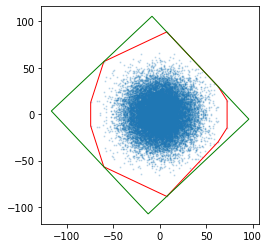

In [8]:
it = FftTransformer(pixels=124)
_ = it.fit(x_train_norm, plot=True)

In [9]:
x_train_img = it.transform(x_train_norm)
x_train_img.shape

(214, 124, 124, 3)

In [10]:
x_test_img = it.transform(x_test_norm)
x_test_img.shape

(54, 124, 124, 3)

Train img
16cell
blast
16cell
8cell
2cell
16cell
8cell
16cell
blast
8cell


<Figure size 1080x288 with 0 Axes>

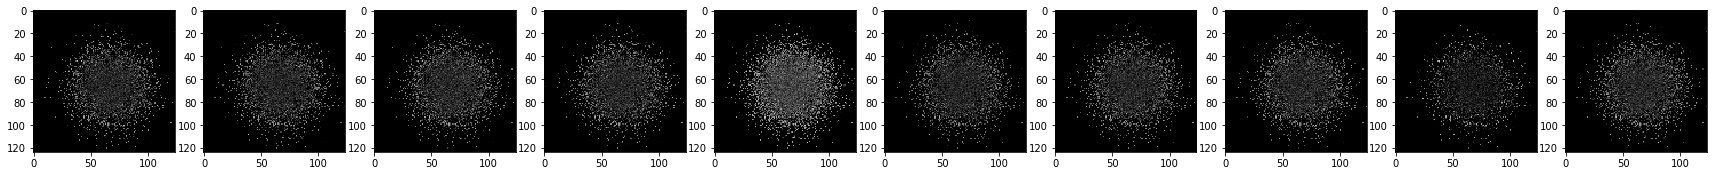

In [11]:
print("Train img")
plt.figure(figsize=(15,4))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,10,figsize=(30,30)) 

for i in range(10):
    axarr[i].imshow(x_train_img[i])
    print(y_train[i])

Test img
16cell
blast
16cell
8cell
2cell
16cell
8cell
16cell
blast
8cell


<Figure size 1080x288 with 0 Axes>

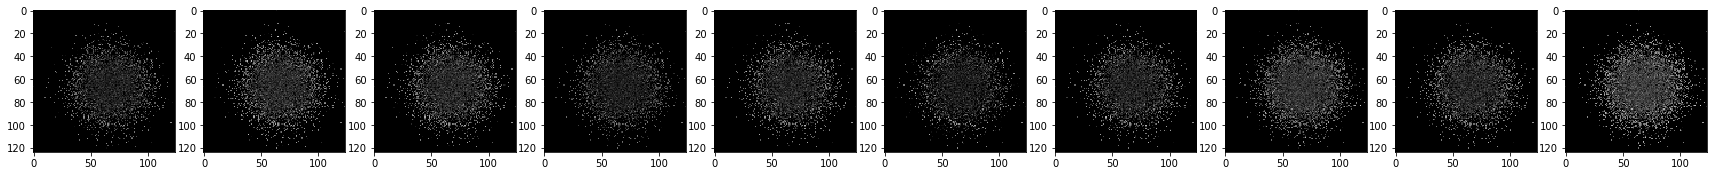

In [12]:
print("Test img")
plt.figure(figsize=(15,4))
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,10,figsize=(30,30)) 

for i in range(10):   
    axarr[i].imshow(x_test_img[i])
    print(y_train[i])

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras import layers
import numpy as np

In [17]:
label = unique_classes.tolist()

n_lst=[]
for i in range(len(y_train)):
  for j in range(len(label)):
    if y_train[i] == label[j]:

      n_lst.append(j)

y_new_train = np.array(n_lst,dtype='float64')

n_lst=[]
for i in range(len(y_test)):
  for j in range(len(label)):
    if y_test[i] == label[j]:
      n_lst.append(j)

y_new_test = np.array(n_lst,dtype='float64')

In [18]:
df_y_train = to_categorical(y_new_train,num_classes=len(label))

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint , ReduceLROnPlateau


model = Sequential()
model.add(Conv2D(64,(3,3),input_shape=(124,124,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3) ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(len(label)))
model.add(Activation('sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, min_delta=1e-4, mode='auto')

model.fit(x_train_img, df_y_train, batch_size=32, epochs=90, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.2)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 171 samples, validate on 43 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/90
171/171 [==============================] - 3s 18ms/sample - loss: 1.6897 - acc: 0.4094 - val_loss: 1.3680 - val_acc: 0.6279
Epoch 2/90
171/171 [==============================] - 2s 12ms/sample - loss: 1.4518 - acc: 0.4620 - val_loss: 1.0917 - val_acc: 0.6279
Epoch 3/90
171/171 [==============================] - 2s 12ms/sample - loss: 1.1250 - acc: 0.4620 - val_loss: 0.7777 - val_acc: 0.6279
Epoch 4/90
171/171 [==============================] - 2s 12ms/sample - loss: 0.8568 - acc: 0.4620 - val_loss: 0.5985 - val_acc: 0.6279
Epoch 5/90
171/171 [==============================] - 2s 12ms/sample - loss: 0.6927 - acc: 0.4620 - val_loss: 0.5169 - val_acc: 0.6279
Epoch 6/90
171/171 [==============================] - 2s 12ms/sample

In [20]:
df_y_test = to_categorical(y_new_test,num_classes=len(label))

val_loss, val_acc = model.evaluate(x_test_img,df_y_test)
print(val_loss, val_acc)

54/54 [==============================] - 0s 5ms/sample - loss: 0.4943 - acc: 0.5000
0.494338513524444 0.5


In [21]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_pred = model.predict(x_test_img)
y_pred = np.argmax(y_pred,axis=1)

out_acc = accuracy_score(y_new_test, y_pred)
out_f1 = f1_score(y_new_test, y_pred,average ='micro')

print("Accuracy: {}".format(round(out_acc,4)))
print("F1 Score(micro): {}".format(round(out_f1,4)))

out_f1 = f1_score(y_new_test, y_pred,average ='macro')
print("F1 Score(macro): {}".format(round(out_f1,4)))

out_f1 = f1_score(y_new_test, y_pred,average ='weighted')
print("F1 Score(weighted): {}".format(round(out_f1,4)))

Accuracy: 0.5
F1 Score(micro): 0.5
F1 Score(macro): 0.1111
F1 Score(weighted): 0.3333


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
